In [1]:
from typing import Tuple, List, Dict
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy import stats

import tqdm
tqdm.tqdm.pandas()

from joblib import Parallel, delayed

from scipy.stats import norm
from functools import partial

from sklearn.linear_model import LinearRegression

import vectorbt as vbt


In [2]:
from market_data import MarketData

# Parameters

In [3]:
start_date = '2017-01-01'

In [4]:
analysis_dir = Path('analysis')

# Pair Selection

In [5]:
pair_df = pd.read_csv(analysis_dir / 'pairs.csv')
pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR
0,ICE,ZBRA,0.999990,4267,0.921816,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,Zebra Technologies Corporation,Technology,Communication Equipment,False,False,-0.307507,1.246738,-4171.347385,-15206.826017,547.383064,0.422320,0.544870,-0.032960,-0.058654,-0.033591,-0.054747
1,JNPR,TPR,0.999990,5551,-0.123542,"Juniper Networks, Inc.",Technology,Communication Equipment,"Tapestry, Inc.",Consumer Cyclical,Luxury Goods,False,False,2.893194,0.140865,463.511463,3794.351841,1176.724157,0.528819,0.499346,-0.049623,-0.077658,-0.038379,-0.062078
2,MBI,LULU,0.999989,3843,-0.027899,MBIA Inc.,Financial Services,Insurance—Specialty,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,False,False,2.896420,0.563837,1972.747682,-2752.406489,910.641747,0.511336,0.438883,-0.048364,-0.084237,-0.044949,-0.073931
3,EBAY,LSI,0.999989,6065,0.914633,eBay Inc.,Consumer Cyclical,Internet Retail,"Life Storage, Inc.",Real Estate,REIT—Industrial,False,False,1.496467,0.739130,29832.125027,-2830.423523,1121.945354,0.494545,0.429923,-0.040757,-0.069210,-0.024821,-0.042188
4,JPM,WTW,0.999989,5381,0.948272,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,Willis Towers Watson Public Limited Company,Financial Services,Insurance Brokers,True,False,2.095041,0.652963,-13438.627734,-4997.649075,699.759923,0.478669,0.377684,-0.034680,-0.054405,-0.023175,-0.038785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22530,BWA,LBTYK,0.950007,4316,0.875707,BorgWarner Inc.,Consumer Cyclical,Auto Parts,Liberty Global plc,Communication Services,Telecom Services,False,False,-0.179080,0.947352,8348.932040,5960.763182,657.721274,0.475160,0.451980,-0.034694,-0.052044,-0.030287,-0.049510
22531,LIN,SO,0.950006,6248,0.923458,Linde plc,Basic Materials,Specialty Chemicals,The Southern Company,Utilities,Utilities—Regulated Electric,False,False,1.562967,0.467798,-2129.422834,-6322.536823,704.915707,0.394240,0.361833,-0.026850,-0.039937,-0.019140,-0.030212
22532,KR,PPG,0.950005,6248,0.901057,The Kroger Co.,Consumer Defensive,Grocery Stores,"PPG Industries, Inc.",Basic Materials,Specialty Chemicals,False,False,0.882089,1.095208,-4207.621220,-16711.488530,8431.579082,0.442471,0.479466,-0.027641,-0.044010,-0.027124,-0.040719
22533,DHI,ETSY,0.950004,1900,0.925374,"D.R. Horton, Inc.",Consumer Cyclical,Residential Construction,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False,-5.481609,2.388161,-5170.915493,1319.830553,797.320137,0.461235,0.532347,-0.042125,-0.063906,-0.056610,-0.086710


In [70]:
selected_pair_df = pair_df[
    (pair_df['cointegration'] > 0.95)
    # & (pair_df['correlation'] > 0.90)
    # Average Spread
    & ((pair_df['spread_half_life'] > 0) & (pair_df['spread_half_life'] < 252))
    & ((pair_df[['left_CVaR', 'right_CVaR']] > -0.1).all(axis=1))
    & (pair_df[['left_hurst', 'right_hurst']] < 0.5).all(axis=1)
]
selected_pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR
18,LSXMA,LSXMK,0.999987,1647,0.998782,The Liberty SiriusXM Group,Communication Services,Broadcasting,The Liberty SiriusXM Group,Communication Services,Broadcasting,True,True,-0.055785,1.014518,-159222.496791,-41078.133834,5.907756,0.432876,0.436685,-0.026235,-0.045873,-0.026279,-0.046276
143,BKNG,LSXMK,0.999959,1647,0.862565,Booking Holdings Inc.,Consumer Cyclical,Travel Services,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,-1.810703,0.730387,49648.063651,-41078.133834,125.595781,0.362293,0.436685,-0.051282,-0.090748,-0.026279,-0.046276
151,ICE,TTWO,0.999958,4267,0.956829,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,"Take-Two Interactive Software, Inc.",Communication Services,Electronic Gaming & Multimedia,False,False,-1.561609,1.367735,-4171.347385,-43546.866519,238.844213,0.422320,0.459971,-0.032960,-0.058654,-0.045430,-0.074226
163,GOOGL,STE,0.999956,4582,0.978620,Alphabet Inc.,Communication Services,Internet Content & Information,STERIS plc,Healthcare,Medical Devices,False,False,1.444649,0.795622,-3136.532795,-3551.796183,239.648860,0.473351,0.359884,-0.028370,-0.043380,-0.031358,-0.050849
177,CCI,EQIX,0.999951,5590,0.972993,Crown Castle Inc.,Real Estate,REIT—Specialty,"Equinix, Inc.",Real Estate,REIT—Specialty,True,True,0.462317,1.160233,-10356.194271,7426.209567,231.529535,0.356932,0.421101,-0.041981,-0.068874,-0.047933,-0.087321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22340,KMB,OKTA,0.950552,1401,0.667720,Kimberly-Clark Corporation,Consumer Defensive,Household & Personal Products,"Okta, Inc.",Technology,Software—Infrastructure,False,False,-21.013941,5.278762,-14962.247736,1554.858154,163.900523,0.403954,0.477909,-0.020329,-0.032141,-0.054657,-0.078982
22402,ZTS,CIEN,0.950354,2454,0.949325,Zoetis Inc.,Healthcare,Drug Manufacturers—Specialty & Generic,Ciena Corporation,Technology,Communication Equipment,False,False,0.722014,0.618353,-2640.185967,260.131580,201.903094,0.460535,0.428151,-0.023942,-0.035218,-0.057493,-0.094998
22451,AMCR,SIRI,0.950233,2633,0.589659,Amcor plc,Consumer Cyclical,Packaging & Containers,Sirius XM Holdings Inc.,Communication Services,Entertainment,False,False,-2.145311,1.578078,-27446.453669,512.631001,164.184156,0.410399,0.488687,-0.022563,-0.038406,-0.060086,-0.099416
22454,CHRW,SEDG,0.950216,1914,0.736041,"C.H. Robinson Worldwide, Inc.",Industrials,Integrated Freight & Logistics,"SolarEdge Technologies, Inc.",Technology,Solar,False,False,-18.526830,5.143101,-11207.821427,2030.805019,181.831152,0.385537,0.328918,-0.029926,-0.047543,-0.057787,-0.086121


In [71]:
]

SyntaxError: unmatched ']' (1890416573.py, line 1)

# Market Data

In [72]:
market_data = MarketData('dataset')
symbols = pd.concat([selected_pair_df['left_symbol'], selected_pair_df['right_symbol']]).unique()
price_df = market_data.read_batch(symbols)
price_df = price_df.loc[start_date:]
price_df

100%|██████████| 286/286 [00:03<00:00, 84.59it/s]


,LSXMA,BKNG,ICE,GOOGL,CCI,GOOG,DE,NTRS,NLOK,DRI,AMT,PM,APTV,ARE,EXPD,CL,HSIC,NSC,CTLT,LOW,EW,IR,ECL,HD,AIZ,VICI,CBOE,TDG,AMCR,BDX,PKI,PCAR,MCO,TFC,IQV,MCHP,LH,ADSK,ALLE,DELL,MTB,NWS,D,GL,DUK,COO,CHD,DHI,IBM,AVY,PEG,CDW,SPGI,LW,HPE,EXPE,ZBH,ANSS,INVH,CPRT,KSS,HCA,CSX,PSX,PPG,AXP,TECH,WHR,ROP,WU,ADI,STE,HOLX,NDSN,MDLZ,ACN,LMT,BBY,KMB,STZ,HUM,AKAM,MPC,WDC,DPZ,PNC,PPL,TDY,AVGO,WTW,EMR,ALL,KMX,DLR,MRK,SNA,AMD,LYB,MA,NRG,RE,FANG,KEY,APH,ODFL,FMC,MET,BIIB,CMA,AMAT,LUMN,BHF,FLT,NYT,SHW,TWTR,JBHT,FIS,LYV,EVRG,ORLY,GM,AZN,FTV,NOW,PKG,JKHY,EIX,EBAY,ULTA,PFG,WBA,DISH,MDT,APD,CHRW,UNP,SYK,V,LBTYK,BATRK,HBAN,LDOS,TJX,IEX,OMC,ZION,HLT,DFS,QRVO,HOG,BATRA,GILD,ANET,RTX,COST,CHTR,ALK,VRSK,RL,LNT,BK,SGEN,FRT,HSY,DOV,INCY,GPN,PH,HAS,TXN,HRL,ROST,MNST,ROK,DTE,CNP,ITW,SEDG,CTAS,PNR,XLNX,MCD,EFX,FWONK,IFF,UHS,MAR,AEP,LEN,HRB,JWN,ZTS,LSXMK,TTWO,EQIX,ON,LHX,RMD,BC,INFO,JD,NVR,OKTA,SANM,POOL,SIRI,WEC,FLEX,STR,TSLA,TMO,MELI,INFY,SII,TEL,MLM,JBL,NEE,LSI,VRSN,DGX,YUM,VMC,RNWK,MRVL,CIEN,LRCX,WAT,ORCL,CNXT,CAG,GME,PANW,MPWR,LILAK,NTES,NVDA,INTU,WDAY,PLD,FHN,AN,AIV,WRK,EA,HII,JNJ,ISRG,ASND,GWW,LILA,CRUS,PBCT,NAVI,SWN,ROL,SPLK,PHM,HST,TFX,ASML,TER,SJM,CHKP,TGNA,MMI,ADTN,GNTX,CSGP,QGEN,FTNT,MAA,QCOM,WM,KLAC,NXPI,TEVA,FWONA,MOH,ES,TGT,J,FSLR,TCOM,EYE
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,33.9233,1477.569946,56.220001,40.400501,86.800003,39.306999,104.050003,89.639999,24.010000,72.059998,106.150002,91.230003,56.613579,110.580002,53.099998,65.540001,61.1490,106.989998,27.00,70.949997,31.840000,NaN,118.040001,134.309998,94.120003,NaN,73.010002,250.539993,10.63,161.121948,52.990002,65.320000,95.470001,46.979999,76.93,31.924999,129.070007,76.18,64.699997,15.314722,156.740005,12.05,76.250000,73.919998,77.730003,175.149994,44.340000,27.559999,159.837479,70.139999,43.389999,51.540001,108.389999,37.490002,13.484004,112.440002,100.320389,93.349998,NaN,27.860001,49.779999,74.459999,11.963333,86.790001,95.250000,75.349998,102.610001,182.929993,184.929993,21.969999,72.510002,68.220001,40.150002,113.419998,44.849998,116.459999,253.309998,42.759998,114.559998,154.750000,197.610001,67.57,52.930000,69.430000,158.360001,117.970001,34.029999,124.00,178.339996,123.239998,56.950001,74.169998,64.820000,99.360001,57.395039,171.149994,11.43,86.879997,105.389999,12.30,216.039993,103.25,18.260000,33.715000,57.853333,49.462273,48.377895,291.709991,68.959999,31.940001,25.350000,NaN,144.649994,13.45,91.513336,16.44,96.769997,76.980003,27.40,56.200001,280.82,35.150002,27.709999,44.962341,75.66,85.000000,88.889999,71.750000,29.840000,256.68,58.580002,82.959999,59.69,70.610001,143.399994,72.849998,102.519997,119.430000,79.500000,29.80,20.64,13.320000,50.950001,37.724998,91.220001,85.070000,43.180000,56.204281,72.730003,52.900002,58.939999,20.50,74.160004,24.264999,69.748268,159.729996,285.769989,88.000000,81.320000,90.629997,37.930000,47.959999,53.00,143.399994,103.919998,61.728596,102.320000,70.500000,142.550003,79.800003,73.580002,35.290001,65.610001,45.540001,138.539993,83.582977,24.590000,122.519997,13.20,116.320000,38.918735,59.070000,119.620003,118.760002,31.500000,117.169998,106.709999,82.500000,62.759998,42.202557,22.910000,47.619999,53.590000,33.5300,49.22,358.720001,12.69,102.720001,61.950001,55.380001,35.919998,25.820000,1649.989990,NaN,36.20,104.639999,4.44,58.490002,14.40,NaN,14.466000,143.669998,161.020004,7.370,18.600000,68.959999,223.330002,23.980000,29.6800,56.546665,77.31,92.449997,63.209999,124.639999,4.8000,14.05,24.430000,107.260002,136.43,38.549999,29.2700,39.759998,6.3425,42.313332,83.610001,21.139360,43.632000,25.502501,114.750000,68.38,52.799999,20.000000,49.279999,5.991149,51.220001,79.169998,189.050003,115.839996,71.309998,19.910000,234.449997,21.969839,57.23,19.290001,16.620001,9.97,14.884444,52.50,18.5499

In [73]:
daily_expected_returns = price_df.pct_change().mean() 
annualized_expected_returns = (1 + daily_expected_returns)**252 - 1
annualized_expected_returns.sort_values(ascending=False)

GME      1.775842
SEDG     0.994425
STR      0.955656
TSLA     0.935441
FTNT     0.599371
           ...   
LILAK   -0.061960
WBA     -0.087319
TEVA    -0.104479
LUMN    -0.110885
DISH    -0.120740
Length: 286, dtype: float64

# Backtesting

In [74]:
pair = selected_pair_df.iloc[0]

pair


left_symbol                                       LSXMA
right_symbol                                      LSXMK
cointegration                                  0.999987
cointegration_test_period                          1647
correlation                                    0.998782
left_companyName             The Liberty SiriusXM Group
left_sector                      Communication Services
left_industry                              Broadcasting
right_companyName            The Liberty SiriusXM Group
right_sector                     Communication Services
right_industry                             Broadcasting
same_sector                                        True
same_industry                                      True
alpha                                         -0.055785
beta                                           1.014518
left_half_life                           -159222.496791
right_half_life                           -41078.133834
spread_half_life                               5

In [75]:
def cross_up(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a > b) & (a.shift(1) <= b.shift(1))
def cross_down(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a < b) & (a.shift(1) >= b.shift(1))

class PairTrading:
    def __init__(
        self,
        left_price: pd.Series,
        right_price: pd.Series,
        left_symbol: str,
        right_symbol: str,
        capital: str,
        left_allocation: float,
        right_allocation: float,
    ):
        self.left_price = left_price
        self.right_price = right_price
        self.left_symbol = left_symbol
        self.right_symbol = right_symbol
        self.capital = capital
        self.left_allocation = left_allocation
        self.right_allocation = right_allocation

    def simulate_pair_trading(
            self,
            spread: pd.Series, 
            lower_bound: pd.Series,
            upper_bound: pd.Series,
            spread_exit: pd.Series,
    ) -> Tuple[vbt.Portfolio, vbt.Portfolio]:
        # Long pair
        long_pair_entry = cross_up(spread, lower_bound)
        long_pair_exit = cross_up(spread, spread_exit)

        # Short pair
        short_pair_entry = cross_down(spread, upper_bound)
        short_pair_exit = cross_down(spread, spread_exit)

        left_long_entry = short_pair_entry
        left_long_exit = short_pair_exit

        right_long_entry = long_pair_entry
        right_long_exit = long_pair_exit

        left_short_entry = long_pair_entry
        left_short_exit = long_pair_exit

        right_short_entry = short_pair_entry
        right_short_exit = short_pair_exit

        left_portfolio = vbt.Portfolio.from_signals(
            self.left_price,
            entries=left_long_entry,
            exits=left_long_exit,
            short_entries=left_short_entry,
            short_exits=left_short_exit,
            init_cash=self.capital*self.left_allocation,
            freq='D',
            fees=0.001,
        )
        right_portfolio = vbt.Portfolio.from_signals(
            self.right_price,
            entries=right_long_entry,
            exits=right_long_exit,
            short_entries=right_short_entry,
            short_exits=right_short_exit,
            init_cash=self.capital*self.right_allocation,
            freq='D',
            fees=0.001,
        )

        return left_portfolio, right_portfolio
    
    def create_buy_and_hold(self, prices: pd.Series, capital: float) -> pd.Series:
        return capital / prices.iloc[0] * prices
    
    def get_benchmark(self) -> pd.Series:
        left_benchmark = self.create_buy_and_hold(self.left_price, self.capital*self.left_allocation)
        right_benchmark = self.create_buy_and_hold(self.right_price, self.capital*self.right_allocation)
        benchmark_nav = left_benchmark + right_benchmark
        return benchmark_nav
    
    def get_pair_nav(self, left_portfolio: vbt.Portfolio, right_portfolio: vbt.Portfolio) -> pd.Series:
        left_nav = left_portfolio.value()
        right_nav = right_portfolio.value()
        nav = left_nav + right_nav
        return nav

    def evaluate_performance(self, prices: pd.Series) -> dict:
        prices = prices.dropna()
        total_return = (prices.iloc[-1] / prices.iloc[0] - 1)
        annualized_return = (1 + total_return) ** (252 / len(prices)) - 1

        returns = prices.pct_change()
        annualized_volatility = returns.std() * np.sqrt(252)

        peak = prices.cummax()
        drawdown = (peak - prices) / peak

        max_drawdown = drawdown.max()
        sharpe_ratio = annualized_return / annualized_volatility
        calmar_ratio = annualized_return / max_drawdown
        sortino_ratio = annualized_return / (returns[returns < 0].std() * np.sqrt(252))

        return {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Calmar Ratio': calmar_ratio,
            'Sortino Ratio': sortino_ratio,
        }

    def evaluate_pair_trade(
            self,
            left_portfolio: vbt.Portfolio,
            right_portfolio: vbt.Portfolio,
    ) -> dict:
        with pd.option_context('mode.chained_assignment', None):

            left_trade_df = left_portfolio.trades.records.set_index('id')
            right_trade_df = right_portfolio.trades.records.set_index('id')
            left_trade_df['principal'] = left_trade_df['size'] * left_trade_df['entry_price'] - left_trade_df['entry_fees']
            right_trade_df['principal'] = right_trade_df['size'] * right_trade_df['entry_price'] - right_trade_df['entry_fees']

            trade_df = left_trade_df[['entry_idx', 'exit_idx']]

            trade_df[['left_principal', 'left_pnl', 'left_direction']] = left_trade_df[['principal', 'pnl', 'direction']]
            trade_df[['right_principal', 'right_pnl', 'right_direction']] = right_trade_df[['principal', 'pnl', 'direction']]
            trade_df['principal'] = trade_df['left_principal'] + trade_df['right_principal']
            trade_df['pair_direction'] = np.where(trade_df['right_direction'] == 1, 'long', 'short')
            trade_df['pnl'] = trade_df['left_pnl'] + trade_df['right_pnl']
            trade_df['return'] = trade_df['pnl'] / trade_df['principal']

            dates = left_portfolio.value().index
            trade_df['duration'] = dates[trade_df['exit_idx']] - dates[trade_df['entry_idx']]
        
        avg_pnl_per_trade = trade_df['return'].mean()
        win_count = (trade_df['pnl'] > 0).sum()
        loss_count = (trade_df['pnl'] < 0).sum()
        total_trade = win_count + loss_count
        win_rate = win_count / total_trade

        avg_win_return = trade_df[trade_df['pnl'] > 0]['return'].mean()
        avg_loss_return = trade_df[trade_df['pnl'] < 0]['return'].mean()

        avg_win_duration = trade_df[trade_df['pnl'] > 0]['duration'].mean().days
        avg_loss_duration = trade_df[trade_df['pnl'] < 0]['duration'].mean().days
        total_trade_duration = trade_df['duration'].sum().days
        avg_trade_per_year = total_trade / ((dates[-1] - dates[0]).days) * 252
        avg_trade_duration_per_year = total_trade_duration / ((dates[-1] - dates[0]).days) * 252

        return {
            'Total Trade': total_trade,
            'Win Count': win_count,
            'Loss Count': loss_count,
            'Avg PnL per Trade [%]': avg_pnl_per_trade * 100,
            'Avg Trade per Year': avg_trade_per_year,
            'Win Rate [%]': win_rate * 100,
            'Avg Winning per Trade [%]': avg_win_return * 100,
            'Avg Losing per Trade [%]': avg_loss_return * 100,
            'Avg Winning Duration [days]': avg_win_duration,
            'Avg Losing Duration [days]': avg_loss_duration,
            'Total Trade Duration [days]': total_trade_duration,
            'Avg Trade Duration per Year [days]': avg_trade_duration_per_year,
        }
    
    def plot_summary(
            self,
            left_portfolio: vbt.Portfolio,
            right_portfolio: vbt.Portfolio,
            spread: pd.Series,
            spread_mean: pd.Series,
            lower_bound: pd.Series,
            upper_bound: pd.Series,
            norm_left_price: pd.Series,
            norm_right_price: pd.Series,
            output_path: str = None
    ):
        
        left_nav = left_portfolio.value()
        right_nav = right_portfolio.value()
        nav = left_nav + right_nav

        benchmark_nav = self.get_benchmark()

        fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.03)
        # NAV plot
        fig.add_trace(
            go.Scatter(
                x=nav.index,
                y=left_nav,
                name=self.left_symbol,
                legendgroup='1'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=nav.index,
                y=right_nav,
                name=self.right_symbol,
                legendgroup='1'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=nav.index,
                y=nav,
                name='NAV',
                legendgroup='1'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=benchmark_nav.index,
                y=benchmark_nav,
                name='Benchmark',
                legendgroup='1',
                line=dict(color='grey', dash='dash')
            ),
        )

        # Spread plot
        fig.add_trace(
            go.Scatter(
                x=spread.index, 
                y=spread, 
                name='Spread',

                legendgroup='2'
            ), 
            row=2, 
            col=1
        )

        fig.add_trace(
            go.Scatter(
                x=spread_mean.index,
                y=spread_mean,
                name='Spread Mean',
                legendgroup='2',
                line=dict(color='grey', dash='dash')
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=lower_bound.index,
                y=lower_bound,
                name='Lower Bound',
                legendgroup='2',
                line=dict(color='red', dash='dash')
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=upper_bound.index,
                y=upper_bound,
                name='Upper Bound',
                legendgroup='2',
                line=dict(color='red', dash='dash')
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=norm_left_price.index,
                y=norm_left_price,
                name=self.left_symbol,
                legendgroup='3',
            ),
            row=3, col=1
        )
        fig.add_trace(
            go.Scatter(
                x=norm_right_price.index,
                y=norm_right_price,
                name=self.right_symbol,
                legendgroup='3',
            ),
            row=3, col=1
        )


        fig.update_layout(height=600, width=800, title_text="Summary Plot")
        fig.update_xaxes(showspikes = True) 
        fig.update_yaxes(showline=True)
        fig.update_layout(hovermode='x unified', spikedistance=-1) 
        fig.update_xaxes(spikemode='across+marker')

        fig.write_html(output_path)


In [76]:
def bollinger_bands(prices: pd.Series, window: int, alpha: float) -> Tuple[pd.Series, pd.Series, pd.Series]:

    spread_mean = prices.rolling(window).mean()
    spread_std = prices.rolling(window).std()

    spread_lower = stats.norm.ppf(alpha, loc=spread_mean, scale=spread_std)
    spread_upper = stats.norm.ppf(1 - alpha, loc=spread_mean, scale=spread_std)

    spread_lower = pd.Series(spread_lower, index=prices.index)
    spread_upper = pd.Series(spread_upper, index=prices.index)
    return spread_mean, spread_lower, spread_upper

class BollingerBangPairTrading(PairTrading):
    def __init__(
        self, 
        left_price: pd.Series, 
        right_price: pd.Series, 
        left_symbol: str, 
        right_symbol: str, 
        capital: str, 
    ):
        self.hedge_ratio = self.calculate_hedge_ratio(left_price, right_price)
        left_allocation, right_allocation = self.calculate_pair_allocation(self.hedge_ratio)

        super().__init__(left_price, right_price, left_symbol, right_symbol, capital, left_allocation, right_allocation)

    def calculate_hedge_ratio(self, left_price: pd.Series, right_price: pd.Series) -> float:
        left_price = left_price.to_numpy()
        right_price = right_price.to_numpy()
        left_price = left_price.reshape(-1, 1)
        right_price = right_price.reshape(-1, 1)
        lr = LinearRegression(fit_intercept=False)
        lr.fit(left_price, right_price)
        return lr.coef_[0][0]

    def calculate_pair_allocation(self, hedge_ratio: float) -> Tuple[float, float]:
        left_allocation = 1 / (hedge_ratio + 1)
        right_allocation = 1 - left_allocation
        return left_allocation, right_allocation
    
    def create_spread(self) -> pd.Series:
        return self.right_price - self.left_price
    
    def backtest(
        self,
        bollinger_window: int = 26,
        bollinger_alpha: float = 0.05,
        output_dir: str = None,
    ) -> pd.Series:
        
        spread = self.create_spread()

        spread_mean, lower_bound, upper_bound = bollinger_bands(spread, window=bollinger_window, alpha=bollinger_alpha)

        left_portfolio, right_portfolio = self.simulate_pair_trading(
            spread=spread,
            lower_bound=lower_bound,
            upper_bound=upper_bound,
            spread_exit=spread_mean
        )

        nav = self.get_pair_nav(left_portfolio, right_portfolio)
        benchmark_nav = self.get_benchmark()

        performance_stats = pd.Series(self.evaluate_performance(nav))
        benchmark_performance_stats = pd.Series(self.evaluate_performance(benchmark_nav))
        trade_stats = pd.Series(self.evaluate_pair_trade(left_portfolio, right_portfolio))

        if output_dir is not None:
            output_dir = Path(output_dir)
            output_dir.mkdir(exist_ok=True, parents=True)
            output_path = Path(output_dir) / f'{self.left_symbol}_{self.right_symbol}.html'

            self.plot_summary(
                left_portfolio=left_portfolio,
                right_portfolio=right_portfolio,
                spread=spread,
                spread_mean=spread_mean,
                lower_bound=lower_bound,
                upper_bound=upper_bound,
                norm_left_price=self.left_price*self.hedge_ratio,
                norm_right_price=self.right_price,
                output_path=str(output_path)
            )

        return pd.concat([
            performance_stats, 
            benchmark_performance_stats.add_prefix('Benchmark - '),
            trade_stats
        ])


In [77]:
def get_pair_price(pair: pd.Series, price_df: pd.DataFrame) -> Tuple[pd.Series]:

    left_symbol = pair['left_symbol']
    right_symbol = pair['right_symbol']

    left_price = price_df[left_symbol]
    right_price = price_df[right_symbol]

    start_date = max(left_price.first_valid_index(), right_price.first_valid_index())
    end_date = min(left_price.last_valid_index(), right_price.last_valid_index())

    left_price = left_price.loc[start_date: end_date]
    right_price = right_price.loc[start_date: end_date]

    return left_price, right_price


In [78]:
def backtest(pair: pd.Series, capital: float = 100_000, **pair_strategy_args) -> pd.Series:
    left_price, right_price = get_pair_price(pair, price_df)
    pair_trading = BollingerBangPairTrading(left_price, right_price, pair['left_symbol'], pair['right_symbol'], capital)
    try:
        backtest_results = pair_trading.backtest(**pair_strategy_args)
        return pd.concat([pair, backtest_results])
    except Exception as e:
        print(f'Error backtesting pair {pair["left_symbol"]} - {pair["right_symbol"]} at index {pair.name}')
        print(e)
        return pd.Series()

In [79]:
output_dir = analysis_dir / 'plot_v2_new'
bollinger_window = 120
bollinger_alpha = 0.30

func = delayed(backtest)
backtest_result_df = pd.DataFrame(
    Parallel(n_jobs=-1)(
        func(
            pair, 
            output_dir=output_dir, 
            bollinger_alpha=bollinger_alpha,
            bollinger_window=bollinger_window,
        )
        for _, pair in tqdm.tqdm(selected_pair_df.iterrows(), total=len(selected_pair_df))
    )
)

 28%|██▊       | 112/400 [01:06<01:28,  3.27it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_14358/3462287990.py:93: RuntimeWarning:

invalid value encountered in double_scalars

 30%|███       | 120/400 [01:08<01:23,  3.34it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_14358/3462287990.py:93: RuntimeWarning:

invalid value encountered in double_scalars

 40%|████      | 160/400 [01:20<01:12,  3.31it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_14358/3462287990.py:93: RuntimeWarning:

invalid value encountered in double_scalars

 72%|███████▏  | 288/400 [02:10<00:45,  2.47it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_14358/3462287990.py:93: RuntimeWarning:

invalid value encountered in double_scalars

 74%|███████▍  | 296/400 [02:13<00:41,  2.54it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_14358/3462287990.py:93: RuntimeWarning:

invalid value encountered in double_scalars

 88%|████████▊ | 352/400 [02:3

In [80]:
backtest_result_df.sort_values('Total Trade', ascending=False)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
0,LSXMA,LSXMK,0.999987,1647,0.998782,The Liberty SiriusXM Group,Communication Services,Broadcasting,The Liberty SiriusXM Group,Communication Services,Broadcasting,True,True,-0.055785,1.014518,-159222.496791,-41078.133834,5.907756,0.432876,0.436685,-0.026235,-0.045873,-0.026279,-0.046276,-0.119926,-0.021706,0.021188,0.123001,-1.024454,-0.176468,-1.025877,0.266241,0.041382,0.319343,0.529173,0.129586,0.078202,0.152776,74.0,22.0,52.0,-0.171845,8.779661,29.729730,0.199505,-0.328955,8.0,15.0,1009.0,119.711864
182,MET,FWONK,0.984498,2095,0.835716,"MetLife, Inc.",Financial Services,Insurance—Life,Formula One Group,Communication Services,Entertainment,False,False,-1.513250,1.312697,-17081.690660,-2945.319503,239.279189,0.429025,0.416261,-0.033478,-0.057973,-0.028667,-0.048793,0.113167,0.018587,0.137113,0.310628,0.135559,0.059837,0.165758,0.664982,0.091525,0.297065,0.553200,0.308096,0.165446,0.369864,48.0,37.0,11.0,0.286314,5.694915,77.083333,1.564714,-4.013757,12.0,59.0,1125.0,133.474576
207,HPE,HST,0.981447,1771,0.731926,Hewlett Packard Enterprise Company,Technology,Communication Equipment,"Host Hotels & Resorts, Inc.",Real Estate,REIT—Hotel & Motel,False,False,1.311886,0.583935,17309.658561,3394.791696,240.226590,0.473947,0.460071,-0.034362,-0.053632,-0.034945,-0.060459,0.709371,0.096469,0.193877,0.245929,0.497581,0.392264,0.458148,0.016718,0.002852,0.319668,0.536208,0.008922,0.005319,0.012144,47.0,40.0,7.0,1.198753,5.576271,85.106383,2.102225,-3.963940,16.0,70.0,1140.0,135.254237
108,ADI,DELL,0.992403,1562,0.948152,"Analog Devices, Inc.",Technology,Semiconductors,Dell Technologies Inc.,Technology,Computer Hardware,True,False,-2.809677,1.308492,-11767.773556,-4399.022222,169.278711,0.391075,0.450609,-0.041429,-0.061190,-0.031122,-0.055796,0.591424,0.083085,0.134058,0.185962,0.619770,0.446785,0.622702,1.118908,0.137678,0.304211,0.376077,0.452574,0.366089,0.587842,47.0,38.0,9.0,1.010029,5.576271,80.851064,1.632216,-1.616985,9.0,58.0,880.0,104.406780
67,MCHP,NEE,0.997387,6248,0.969235,Microchip Technology Incorporated,Technology,Semiconductors,"NextEra Energy, Inc.",Utilities,Utilities—Regulated Electric,False,False,-0.181964,1.029322,-16218.837452,-2064.922609,226.732572,0.387083,0.340260,-0.042567,-0.064668,-0.021054,-0.033692,0.878562,0.114391,0.210172,0.266708,0.544274,0.428899,0.587484,1.332869,0.156634,0.261908,0.369110,0.598050,0.424356,0.746641,46.0,38.0,8.0,1.464232,5.457627,82.608696,2.550404,-3.695086,20.0,36.0,1058.0,125.525424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,ZBH,OKTA,0.990569,1401,0.715383,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices,"Okta, Inc.",Technology,Software—Infrastructure,False,False,-13.220210,3.691449,164842.878963,1554.858154,154.405196,0.446348,0.477909,-0.026076,-0.041449,-0.054657,-0.078982,-0.259820,-0.052678,0.248097,0.522958,-0.212329,-0.100731,-0.263205,0.724688,0.103005,0.455581,0.783645,0.226096,0.131443,0.293420,11.0,8.0,3.0,-1.876473,1.365517,72.727273,4.181071,-18.

In [81]:
backtest_result_df.sort_values('Avg PnL per Trade [%]', ascending=False)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
264,KSS,GME,0.973787,5215,-0.001119,Kohl's Corporation,Consumer Cyclical,Department Stores,GameStop Corp.,Consumer Cyclical,Specialty Retail,True,False,0.141611,0.405380,2619.548283,122.478184,70.116851,0.475602,0.284337,-0.037639,-0.060746,-0.050629,-0.088007,1.882954,0.199473,2.118284,0.894939,0.094167,0.222890,0.209587,0.414828,0.061421,0.841205,0.856034,0.073016,0.071751,0.109123,28.0,20.0,8.0,18.099455,3.322034,71.428571,34.685336,-23.365246,28.0,80.0,1219.0,144.627119
276,BHF,GME,0.970493,1333,0.320390,"Brighthouse Financial, Inc.",Financial Services,Insurance—Life,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,-9.759127,3.081604,1041.469250,122.478184,73.389276,0.358933,0.284337,-0.048439,-0.075294,-0.050629,-0.088007,2.719752,0.281900,0.569576,0.634380,0.494929,0.444371,0.566870,0.973874,0.137180,1.026490,0.801085,0.133640,0.171243,0.215518,31.0,25.0,6.0,4.802502,4.049767,80.645161,7.918354,-8.180214,15.0,84.0,894.0,116.790047
82,DELL,SII,0.994993,1562,0.876009,Dell Technologies Inc.,Technology,Computer Hardware,Sprott Inc.,Financial Services,Asset Management,False,False,0.870721,0.714439,-4399.022222,1540.081847,213.906055,0.450609,0.498267,-0.031122,-0.055796,-0.040692,-0.063924,1.330369,0.156421,0.108171,0.112366,1.446051,1.392064,1.398892,1.263543,0.150655,0.298300,0.504758,0.505046,0.298471,0.644595,29.0,27.0,2.0,3.005854,3.440678,93.103448,3.382678,-2.081276,13.0,53.0,457.0,54.220339
35,TDG,WEC,0.999182,4187,0.972224,TransDigm Group Incorporated,Industrials,Aerospace & Defense,"WEC Energy Group, Inc.",Utilities,Utilities—Regulated Electric,False,False,1.241926,0.511151,-3429.819094,-3936.152054,160.983067,0.418918,0.339135,-0.030191,-0.050462,-0.018924,-0.029675,1.331492,0.156517,0.202553,0.266467,0.772717,0.587376,0.773481,1.210743,0.146000,0.340518,0.558439,0.428758,0.261442,0.534976,32.0,28.0,4.0,2.756894,3.796610,87.500000,3.360748,-1.470084,18.0,54.0,746.0,88.508475
203,TWTR,VICI,0.982233,1267,0.697450,"Twitter, Inc.",Communication Services,Internet Content & Information,VICI Properties Inc.,Real Estate,REIT—Diversified,False,False,1.303903,0.511291,1483.616316,-3041.852333,214.009881,0.434863,0.400687,-0.045895,-0.079990,-0.028111,-0.055978,0.769170,0.120160,0.244676,0.248080,0.491098,0.484361,0.410494,1.475422,0.197553,0.439307,0.516335,0.449693,0.382607,0.575464,23.0,19.0,4.0,2.717295,3.156863,82.608696,4.551213,-5.993815,19.0,50.0,575.0,78.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,PSX,GME,0.987685,2656,-0.009093,Phillips 66,Energy,Oil & Gas Refining & Marketing,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,2.687246,-0.172889,-7906.934555,122.478184,59.602642,0.477339,0.284337,-0.032729,-0.050107,-0.050629,-0.088007,-1.614960,NaN,13.079492,4.151389,NaN,NaN,NaN,0.613964,0.085705,0.632006,0.663146,0.135608,0.129240,0.190426,12.0,7.0,5.0,-13.289897,1.423729,58.333333,3.733573,-37.122754,14.0,105.0,1103.0,130.864407
391,LEN,TSLA,0.951711,3107,0.840974,Lennar 

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Annualized Return Distribution')

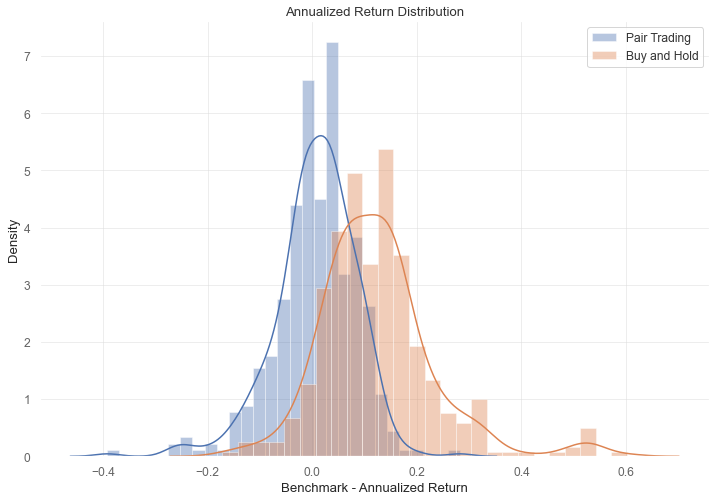

In [82]:


# Plot overlapping histogram
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(backtest_result_df['Annualized Return'], label='Pair Trading', ax=ax)
sns.distplot(backtest_result_df['Benchmark - Annualized Return'], label='Buy and Hold', ax=ax)
ax.legend()
ax.set_title('Annualized Return Distribution')


In [83]:
backtest_result_df['Max Drawdown'].describe()

count    400.000000
mean       0.474938
std        0.845694
min        0.085054
25%        0.220577
50%        0.325131
75%        0.476496
max       12.856094
Name: Max Drawdown, dtype: float64

In [84]:


backtest_result_df[
    (~backtest_result_df[['left_symbol', 'right_symbol']].isin(['GME', 'TSLA']).any(axis=1) )
].sort_values('Total Return', ascending=True)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
286,DFS,HBAN,0.968470,3873,0.713731,Discover Financial Services,Financial Services,Credit Services,Huntington Bancshares Incorporated,Financial Services,Banks—Regional,True,False,0.491232,0.469267,-4992.516032,1880.686535,175.708254,0.487264,0.460339,-0.039411,-0.067226,-0.038052,-0.069985,-1.537295,NaN,1.663418,1.568562,NaN,NaN,NaN,0.408888,0.060654,0.413349,0.698250,0.146739,0.086866,0.179956,15.0,10.0,5.0,-10.347099,1.779661,66.666667,6.534155,-44.109608,37.0,289.0,1820.0,215.932203
117,MDLZ,NVDA,0.991817,5380,0.840310,"Mondelez International, Inc.",Consumer Defensive,Confectioners,NVIDIA Corporation,Technology,Semiconductors,False,False,-17.239660,5.339160,-11168.086051,4181.445464,167.099089,0.406636,0.487559,-0.020013,-0.032552,-0.054423,-0.081799,-1.244766,NaN,4.760827,2.195504,NaN,NaN,NaN,3.106164,0.274605,0.433333,0.634989,0.633704,0.432456,0.864491,9.0,6.0,3.0,-21.919180,1.067797,66.666667,3.507566,-72.772672,15.0,225.0,1061.0,125.881356
7,DE,ON,0.999924,5661,0.935398,Deere & Company,Industrials,Farm & Heavy Construction Machinery,ON Semiconductor Corporation,Technology,Semiconductors,False,False,-1.482168,0.872879,-1196.857321,-1528.138456,210.672085,0.481187,0.439761,-0.031381,-0.048444,-0.056024,-0.086664,-1.056181,NaN,44.373095,1.198830,NaN,NaN,NaN,2.998006,0.268774,0.318358,0.398746,0.844249,0.674047,1.108163,21.0,16.0,5.0,-4.703801,2.491525,76.190476,2.628303,-28.166536,15.0,312.0,1816.0,215.457627
351,APTV,MELI,0.958818,2755,0.870845,Aptiv PLC,Consumer Cyclical,Auto Parts,"MercadoLibre, Inc.",Consumer Cyclical,Internet Retail,True,False,-1.627974,1.719341,13134.404826,2803.037012,251.673316,0.498599,0.485741,-0.032955,-0.052943,-0.051862,-0.080563,-1.005588,NaN,29.346299,1.264445,NaN,NaN,NaN,4.056379,0.321007,0.526647,0.684215,0.609529,0.469160,0.875060,18.0,15.0,3.0,-6.474703,2.135593,83.333333,4.409126,-60.893851,15.0,188.0,1099.0,130.389831
254,AKAM,SEDG,0.975162,1914,0.856089,"Akamai Technologies, Inc.",Technology,Software—Infrastructure,"SolarEdge Technologies, Inc.",Technology,Solar,True,False,-10.669541,3.416745,617.024258,2030.805019,149.020466,0.465079,0.328918,-0.053891,-0.090430,-0.057787,-0.086121,-0.944775,-0.391969,65.978736,1.474156,-0.005941,-0.265894,-0.008187,10.745479,0.526798,0.582818,0.487252,0.903880,1.081161,1.336978,15.0,8.0,7.0,-7.547717,1.779661,53.333333,3.835976,-20.557652,18.0,94.0,1130.0,134.067797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,GOOGL,IR,0.959466,1377,0.935496,Alphabet Inc.,Communication Services,Internet Content & Information,Ingersoll Rand Inc.,Industrials,Specialty Industrial Machinery,False,False,0.432367,0.723326,-3136.532795,-2329.547717,147.496795,0.473351,0.458334,-0.028370,-0.043380,-0.035749,-0.052718,1.077583,0.143182,0.153929,0.151645,0.930177,0.944190,1.121308,1.129728,0.148380,0.275673,0.368648,0.538244,0.402496,0.711296,39.0,34.0,5.0,2.041024,4.926316,87.179487,2.734954,-2.677706,20.0,71.0,1046.0,132.126316
387,ADI,IR,0.953077,1377,0.940274,"

In [85]:
backtest_result_df.sort_values('Max Drawdown', ascending=True)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
242,ARE,ZTS,0.976535,2454,0.960197,"Alexandria Real Estate Equities, Inc.",Real Estate,REIT—Office,Zoetis Inc.,Healthcare,Drug Manufacturers—Specialty & Generic,False,False,-4.446858,1.840239,-19081.135780,-2640.185967,159.837100,0.433764,0.460535,-0.025696,-0.044859,-0.023942,-0.035218,0.275634,0.042705,0.071043,0.085054,0.601118,0.502097,0.589358,1.033860,0.129700,0.226305,0.417549,0.573121,0.310622,0.708368,44.0,40.0,4.0,0.561026,5.220339,90.909091,0.784652,-1.675235,13.0,42.0,700.0,83.050847
16,GOOGL,RMD,0.999793,4582,0.980811,Alphabet Inc.,Communication Services,Internet Content & Information,ResMed Inc.,Healthcare,Medical Instruments & Supplies,False,False,0.926481,0.925638,-3136.532795,-2090.997069,239.373101,0.473351,0.445210,-0.028370,-0.043380,-0.031168,-0.055532,0.610696,0.085327,0.125602,0.103030,0.679343,0.828180,0.835086,2.142131,0.217342,0.278633,0.339165,0.780030,0.640816,0.963614,29.0,26.0,3.0,1.693299,3.440678,89.655172,2.204852,-2.740157,20.0,86.0,793.0,94.084746
82,DELL,SII,0.994993,1562,0.876009,Dell Technologies Inc.,Technology,Computer Hardware,Sprott Inc.,Financial Services,Asset Management,False,False,0.870721,0.714439,-4399.022222,1540.081847,213.906055,0.450609,0.498267,-0.031122,-0.055796,-0.040692,-0.063924,1.330369,0.156421,0.108171,0.112366,1.446051,1.392064,1.398892,1.263543,0.150655,0.298300,0.504758,0.505046,0.298471,0.644595,29.0,27.0,2.0,3.005854,3.440678,93.103448,3.382678,-2.081276,13.0,53.0,457.0,54.220339
332,HD,DELL,0.960800,1562,0.938177,"The Home Depot, Inc.",Consumer Cyclical,Home Improvement Retail,Dell Technologies Inc.,Technology,Computer Hardware,False,False,-3.302454,1.234121,-2434.524832,-4399.022222,241.922220,0.467559,0.450609,-0.029263,-0.044940,-0.031122,-0.055796,0.658989,0.090849,0.117638,0.113173,0.772273,0.802740,0.702057,1.264063,0.150701,0.257559,0.384331,0.585113,0.392113,0.675612,27.0,23.0,4.0,1.916952,3.203390,85.185185,2.554613,-1.749600,13.0,83.0,638.0,75.694915
274,CPRT,ZTS,0.970757,2454,0.991577,"Copart, Inc.",Consumer Cyclical,Auto & Truck Dealerships,Zoetis Inc.,Healthcare,Drug Manufacturers—Specialty & Generic,False,False,1.328624,0.797780,-1899.695093,-2640.185967,232.462962,0.479538,0.460535,-0.032136,-0.052261,-0.023942,-0.035218,0.153084,0.024770,0.099978,0.113175,0.247755,0.218865,0.244107,2.389897,0.233318,0.243782,0.395893,0.957076,0.589345,1.230471,39.0,30.0,9.0,0.394772,4.627119,76.923077,1.296436,-2.610775,17.0,57.0,1032.0,122.440678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,LEN,TSLA,0.951711,3107,0.840974,Lennar Corporation,Consumer Cyclical,Residential Construction,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,True,False,-8.142921,2.893832,448488.585642,8115.459361,188.753792,0.447803,0.433932,-0.042187,-0.067775,-0.050143,-0.077931,-2.162740,NaN,8.924020,2.603754,NaN,NaN,NaN,10.110028,0.512279,0.534320,0.598670,0.958750,0.855696,1.338505,13.0,8.0,5.0,-19.924452,1.542373,61.538462,4.758286,-59.416833,31.0,110.0,1072.0,127.186441

In [86]:
backtest_result_df[backtest_result_df['Win Count'] < backtest_result_df['Loss Count']]

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
0,LSXMA,LSXMK,0.999987,1647,0.998782,The Liberty SiriusXM Group,Communication Services,Broadcasting,The Liberty SiriusXM Group,Communication Services,Broadcasting,True,True,-0.055785,1.014518,-159222.496791,-41078.133834,5.907756,0.432876,0.436685,-0.026235,-0.045873,-0.026279,-0.046276,-0.119926,-0.021706,0.021188,0.123001,-1.024454,-0.176468,-1.025877,0.266241,0.041382,0.319343,0.529173,0.129586,0.078202,0.152776,74.0,22.0,52.0,-0.171845,8.779661,29.729730,0.199505,-0.328955,8.0,15.0,1009.0,119.711864
47,MCHP,SPGI,0.998623,6248,0.971776,Microchip Technology Incorporated,Technology,Semiconductors,S&P Global Inc.,Financial Services,Financial Data & Stock Exchanges,False,False,0.637000,1.197354,-16218.837452,-2863.857241,224.213233,0.387083,0.474293,-0.042567,-0.064668,-0.026471,-0.043822,-0.385477,-0.080238,0.183897,0.450283,-0.436323,-0.178196,-0.429130,1.846512,0.196855,0.273109,0.395900,0.720792,0.497234,0.900866,11.0,4.0,7.0,-4.039658,1.305085,36.363636,1.142465,-7.000872,10.0,134.0,980.0,116.271186
146,D,ASND,0.988400,1954,0.389592,"Dominion Energy, Inc.",Utilities,Utilities—Regulated Electric,Ascendis Pharma A/S,Healthcare,Biotechnology,False,False,-17.078623,4.888596,-24693.034118,6566.030153,199.052476,0.355561,0.437738,-0.020232,-0.032377,-0.042327,-0.059990,-0.349135,-0.071116,0.250609,0.486811,-0.283772,-0.146085,-0.250530,2.501302,0.240187,0.455947,0.526295,0.526788,0.456374,1.005097,21.0,10.0,11.0,-1.667228,2.491525,47.619048,4.531441,-7.302381,12.0,113.0,1369.0,162.423729
371,HSIC,SEDG,0.955876,1914,0.637567,"Henry Schein, Inc.",Healthcare,Medical Distribution,"SolarEdge Technologies, Inc.",Technology,Solar,False,False,-14.362304,4.441958,-6651.637256,2030.805019,182.560635,0.426639,0.328918,-0.028941,-0.047972,-0.057787,-0.086121,-0.809559,-0.247896,0.501444,0.820211,-0.494364,-0.302234,-0.505360,11.420027,0.541514,0.594296,0.505119,0.911186,1.072051,1.344041,9.0,3.0,6.0,-10.560916,1.067797,33.333333,7.904720,-19.793734,115.0,109.0,1343.0,159.338983
374,GILD,OKTA,0.955585,1401,-0.346575,"Gilead Sciences, Inc.",Healthcare,Drug Manufacturers—General,"Okta, Inc.",Technology,Software—Infrastructure,False,False,20.896922,-3.860102,-17718.688315,1554.858154,212.811974,0.438858,0.477909,-0.036784,-0.060814,-0.054657,-0.078982,-0.730183,-0.209930,1.094574,0.949664,-0.191792,-0.221057,-0.260650,0.991129,0.131878,0.480828,0.796252,0.274272,0.165623,0.358830,22.0,10.0,12.0,-4.312469,2.731034,45.454545,1.569553,-9.214154,13.0,86.0,1168.0,144.993103


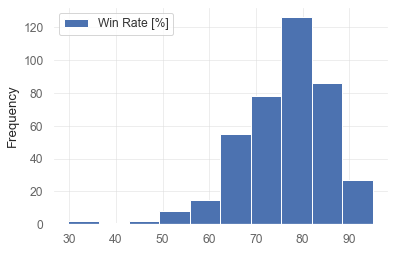

In [87]:
backtest_result_df.plot.hist(y='Win Rate [%]')

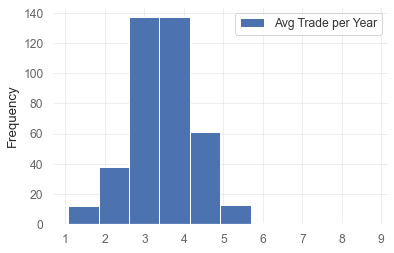

In [88]:
backtest_result_df.plot.hist(y='Avg Trade per Year')

In [89]:
backtest_result_df.sort_values('Sharpe Ratio', ascending=False)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg PnL per Trade [%],Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
82,DELL,SII,0.994993,1562,0.876009,Dell Technologies Inc.,Technology,Computer Hardware,Sprott Inc.,Financial Services,Asset Management,False,False,0.870721,0.714439,-4399.022222,1540.081847,213.906055,0.450609,0.498267,-0.031122,-0.055796,-0.040692,-0.063924,1.330369,0.156421,0.108171,0.112366,1.446051,1.392064,1.398892,1.263543,0.150655,0.298300,0.504758,0.505046,0.298471,0.644595,29.0,27.0,2.0,3.005854,3.440678,93.103448,3.382678,-2.081276,13.0,53.0,457.0,54.220339
162,IBM,LILAK,0.986753,1853,0.479170,International Business Machines Corporation,Technology,Information Technology Services,Liberty Latin America Ltd.,Communication Services,Telecom Services,False,False,-9.117659,2.437677,21764.420579,366.476459,236.414296,0.434086,0.330224,-0.025553,-0.040758,-0.039173,-0.066342,1.562215,0.175416,0.166305,0.249195,1.054788,0.703932,0.946166,-0.184231,-0.034374,0.257728,0.493743,-0.133372,-0.069619,-0.165837,40.0,38.0,2.0,2.408897,4.745763,95.000000,2.635425,-1.895135,18.0,28.0,752.0,89.220339
17,PM,BHF,0.999776,1333,0.846976,Philip Morris International Inc.,Consumer Defensive,Tobacco,"Brighthouse Financial, Inc.",Financial Services,Insurance—Life,False,False,-2.785941,1.456840,-26307.743395,1041.469250,150.342399,0.425865,0.358933,-0.021686,-0.036062,-0.048439,-0.075294,0.695946,0.105019,0.112734,0.117256,0.931562,0.895635,1.010833,-0.209603,-0.043494,0.282553,0.587408,-0.153931,-0.074043,-0.184535,38.0,36.0,2.0,1.421219,4.964230,94.736842,1.801612,-5.425864,14.0,110.0,737.0,96.279938
344,GOOGL,IR,0.959466,1377,0.935496,Alphabet Inc.,Communication Services,Internet Content & Information,Ingersoll Rand Inc.,Industrials,Specialty Industrial Machinery,False,False,0.432367,0.723326,-3136.532795,-2329.547717,147.496795,0.473351,0.458334,-0.028370,-0.043380,-0.035749,-0.052718,1.077583,0.143182,0.153929,0.151645,0.930177,0.944190,1.121308,1.129728,0.148380,0.275673,0.368648,0.538244,0.402496,0.711296,39.0,34.0,5.0,2.041024,4.926316,87.179487,2.734954,-2.677706,20.0,71.0,1046.0,132.126316
173,IR,ORCL,0.985382,1377,0.913426,Ingersoll Rand Inc.,Industrials,Specialty Industrial Machinery,Oracle Corporation,Technology,Software—Infrastructure,False,False,1.654871,0.680987,-2329.547717,-4715.708003,192.329644,0.458334,0.447910,-0.035749,-0.052718,-0.037996,-0.058065,0.889172,0.123465,0.140651,0.136321,0.877808,0.905690,0.884393,0.973665,0.132497,0.269604,0.361925,0.491449,0.366089,0.670589,29.0,26.0,3.0,2.266038,3.663158,89.655172,2.789563,-2.271182,23.0,71.0,816.0,103.073684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,PSX,GME,0.987685,2656,-0.009093,Phillips 66,Energy,Oil & Gas Refining & Marketing,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,2.687246,-0.172889,-7906.934555,122.478184,59.602642,0.477339,0.284337,-0.032729,-0.050107,-0.050629,-0.088007,-1.614960,NaN,13.079492,4.151389,NaN,NaN,NaN,0.613964,0.085705,0.632006,0.663146,0.135608,0.129240,0.190426,12.0,7.0,5.0,-13.289897,1.423729,58.333333,3.733573,-37.1

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Max Drawdown Distribution')

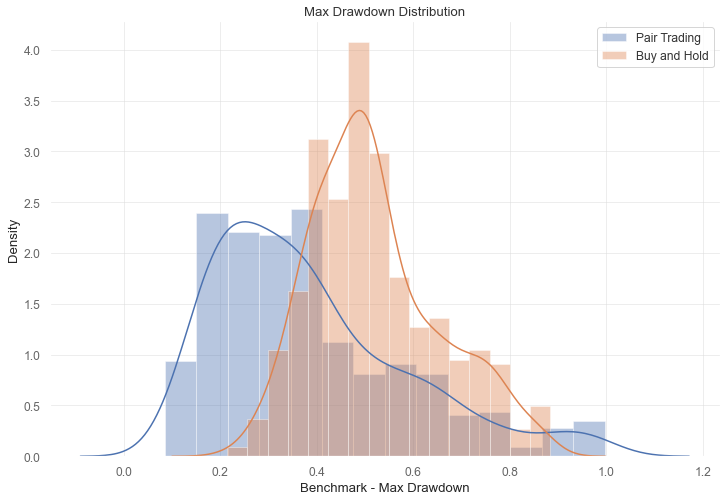

In [34]:
# Plot overlapping histogram
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(backtest_result_df.loc[backtest_result_df['Max Drawdown'] < 1, 'Max Drawdown'], label='Pair Trading', ax=ax)
sns.distplot(backtest_result_df['Benchmark - Max Drawdown'], label='Buy and Hold', ax=ax)
ax.legend()
ax.set_title('Max Drawdown Distribution')


In [35]:
backtest_result_df.describe()

,cointegration,cointegration_test_period,correlation,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,511.000000,528.000000,528.000000,511.000000,511.000000,511.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.00000,528.000000,528.000000,528.000000,528.000000,527.000000,528.000000,527.000000,528.000000,528.000000,528.000000
mean,0.979475,2447.460227,0.690116,-0.963336,1.107288,-3061.334157,-1850.574736,193.795733,0.445385,0.440340,-0.032421,-0.052401,-0.038909,-0.062904,0.017164,-0.000734,5.013321,0.543375,0.098773,0.088208,0.100352,1.380947,0.132486,0.347157,0.520005,0.389892,0.274061,0.516908,27.50947,20.943182,6.566288,3.341285,74.563100,2.834622,-10.044930,19.102467,114.924242,1061.490530,128.869044
std,0.015145,1393.754530,0.440836,6.299120,1.494110,54394.104824,31746.774695,46.135823,0.046071,0.060284,0.008214,0.013674,0.011716,0.017992,0.716097,0.090689,43.136111,1.042981,0.334185,0.241898,0.353436,1.827894,0.116350,0.128667,0.133717,0.299993,0.233243,0.402810,8.10673,7.441396,3.267829,0.974325,11.672039,2.120681,15.731090,11.362207,100.273544,250.329104,29.530594
min,0.950185,1261.000000,-0.891655,-40.717119,-5.073766,-258785.054945,-159222.496791,5.907756,0.322074,0.284337,-0.057787,-0.099096,-0.063710,-0.099496,-8.221399,-0.648181,0.021188,0.085054,-1.024454,-0.383242,-1.025877,-0.667927,-0.172519,0.183660,0.214351,-0.474839,-0.241801,-0.675578,2.00000,0.000000,1.000000,0.237288,0.000000,0.199505,-204.442952,3.000000,11.000000,457.000000,54.220339
25%,0.965083,1562.000000,0.697220,-2.718694,0.538102,-6206.031141,-3881.505928,167.422453,0.410666,0.412496,-0.036243,-0.059934,-0.049326,-0.077726,-0.223042,-0.038920,0.148018,0.235312,-0.137497,-0.091909,-0.145658,0.374942,0.058197,0.267633,0.420828,0.167162,0.108781,0.232611,23.00000,16.000000,5.000000,2.728814,68.705357,1.820277,-10.347803,13.000000,74.000000,901.750000,111.737823
50%,0.982253,1914.000000,0.864705,-0.187290,0.912765,-2693.848790,191.304882,203.471590,0.444687,0.440375,-0.030967,-0.050189,-0.038514,-0.059152,0.013044,0.005878,0.190025,0.360357,0.033069,0.018336,0.033806,0.908884,0.122361,0.312387,0.498416,0.375053,0.240354,0.489033,28.00000,21.000000,6.000000,3.322034,76.794872,2.353371,-6.297160,17.000000,99.500000,1050.500000,127.186441
75%,0.993078,2637.500000,0.936183,1.701590,1.456961,2073.189030,1895.309291,231.183892,0.476693,0.477909,-0.026500,-0.042173,-0.028434,-0.048662,0.311140,0.053595,0.271295,0.552045,0.328852,0.214278,0.337618,1.570585,0.184160,0.386633,0.598393,0.622069,0.420068,0.813157,33.00000,26.000000,8.000000,3.915254,82.608696,3.279819,-3.742615,22.000000,128.250000,1176.250000,143.140931
max,0.999987,6248.000000,0.998782,26.164523,10.420919,523508.987917,448488.585642,251.720565,0.560997,0.638368,-0.020013,-0.032029,-0.018923,-0.029135,2.719752,0.281900,647.180919,15.625761,1.446051,1.392064,1.398892,14.537792,0.601975,1.026490,0.883492,1.170522,1.181037,1.645489,74.00000,48.000000,52.000000,8.779661,95.652174,34.685336,-0.328955,128.000000,1199.000000,2401.000000,284.864407
